# 라이브러리 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import folium
import datetime
import random
from sklearn.metrics import mean_absolute_error


# 랜덤 시드 설정

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [3]:
TRAIN_PATH = '../data/train.csv'
TEST_PATH = '../data/test.csv'
SAMPLE_PATH = '../data/sample_submission.csv'
PARK_PATH = '../data/parkInfo.csv'
SCHOOL_PATH = '../data/schoolinfo.csv'
SUBWAY_PATH = '../data/subwayInfo.csv'

In [4]:
_train_data = pd.read_csv(TRAIN_PATH)
_test_data = pd.read_csv(TEST_PATH)
sample_submission = pd.read_csv(SAMPLE_PATH)
park_data = pd.read_csv(PARK_PATH)
school_data = pd.read_csv(SCHOOL_PATH)
subway_data = pd.read_csv(SUBWAY_PATH)

# 데이터 전처리

In [5]:
# Train
# 날짜순으로 정렬
_train_data["contract_year_month_day"] = pd.to_datetime(_train_data["contract_year_month"] * 100 + _train_data["contract_day"], format='%Y%m%d')
train_data = _train_data.copy()
train_data = train_data.sort_values(by="contract_year_month_day")
#train_data.drop(columns=["contract_year_month", "contract_day"], inplace=True)

# 음수 age를 양수로 변환
train_data["age"] = train_data["age"].abs()

# duplicated data 제거
'''dup_df = train_data[train_data.drop(columns="index").duplicated()]
train_data = train_data.drop(index=dup_df.index)'''

train_data.shape

(1801228, 12)

In [6]:
# Test
_test_data["contract_year_month_day"] = pd.to_datetime(_test_data["contract_year_month"] * 100 + _test_data["contract_day"], format='%Y%m%d')
test_data = _test_data.copy()
test_data = test_data.sort_values(by="contract_year_month_day")

# 음수 age를 양수로 변환
test_data["age"] = test_data["age"].abs()

# duplicated data 제거
'''dup_df = test_data[test_data.drop(columns="index").duplicated()]
test_data = test_data.drop(index=dup_df.index)'''

test_data.shape

(150172, 11)

# 클러스터링

In [7]:
# 지구 반경 (단위: km)
R = 6371.0

# 위도, 경도를 라디안으로 변환하는 함수
def to_radians(degrees):
    return degrees * (torch.pi / 180)

# 하버사인 공식에 따른 거리 계산
def haversine_distance(lat1, lon1, lat2, lon2):
    # 위도, 경도를 라디안으로 변환
    lat1, lon1, lat2, lon2 = map(to_radians, (lat1, lon1, lat2, lon2))
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))

    return R * c  # 거리를 km 단위로 반환

# k-means++ 초기화
def initialize_centroids(data, n_clusters):
    n_samples = data.size(0)
    
    # 첫 번째 클러스터 중심은 랜덤하게 선택
    centroids = [data[torch.randint(0, n_samples, (1,)).item()]]
    
    for _ in range(1, n_clusters):
        # 각 데이터 포인트와 가장 가까운 클러스터 중심까지의 거리 계산
        dist = torch.stack([haversine_distance(data[:, 0], data[:, 1], c[0], c[1]) for c in centroids]).min(dim=0)[0]
        
        # 거리의 제곱에 비례하는 확률로 다음 중심을 선택
        probs = dist / dist.sum()
        next_centroid = data[torch.multinomial(probs, 1).item()]
        
        centroids.append(next_centroid)
    
    return torch.stack(centroids)


def kmeans(data, n_clusters, max_iters=100, tol=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    data = torch.tensor(data.values, dtype=torch.float32).to(device)

    # 클러스터 중심 초기화
    centroids = initialize_centroids(data, n_clusters)
    
    for i in range(max_iters):
        # 각 데이터 포인트와 모든 클러스터 중심 간의 지리적 거리 계산
        distances = torch.stack([haversine_distance(data[:, 0], data[:, 1], c[0], c[1]) for c in centroids], dim=1)
        
        # 각 데이터 포인트가 가장 가까운 클러스터 중심에 할당됨
        cluster_assignments = torch.argmin(distances, dim=1)
        
        # 새로운 클러스터 중심 계산
        new_centroids = torch.stack([data[cluster_assignments == k].mean(0) for k in range(n_clusters)])
        
        # 클러스터 중심이 변화한 정도를 확인하여 수렴 판단
        centroid_shift = torch.norm(centroids - new_centroids, dim=1).max()
        
        centroids = new_centroids
        
        if centroid_shift < tol:
            print(f"Converged at iteration {i}")
            break
    
    return centroids, cluster_assignments

In [8]:
train_location = train_data[["latitude", "longitude"]]

In [9]:
# test2, tolerance
n_clusters = 100
max_iters=100
tol=1e-6
centroids_100, cluster_assignments_100 = kmeans(train_location, n_clusters, max_iters, tol)

Using device: cuda
Converged at iteration 24


In [10]:
# test3, cluster줄이기
n_clusters = 80
max_iters=100
tol=1e-6
centroids_80, cluster_assignments_80 = kmeans(train_location, n_clusters, max_iters, tol)

Using device: cuda
Converged at iteration 25


In [11]:
# 결과를 train_data에 저장
train_data['cluster_100'] = cluster_assignments_100.cpu().numpy()
train_data['cluster_80'] = cluster_assignments_80.cpu().numpy()


# 클러스터 중심들의 평균값 계산
clusters = train_data[["cluster_100", "latitude", "longitude", "deposit"]].groupby("cluster_100").mean()

In [12]:
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,contract_year_month_day,cluster_100,cluster_80
942790,942790,59.9100,201904,1,2,12,2016,37.547574,127.012878,3,61000.0,2019-04-01,63,65
22731,22731,59.9940,201904,1,2,23,2005,37.755550,127.075388,14,17000.0,2019-04-01,98,27
22544,22544,84.9454,201904,1,2,9,2017,37.750609,127.103420,2,25000.0,2019-04-01,98,27
1036408,1036408,126.6211,201904,1,2,2,2018,37.480071,127.002332,1,133000.0,2019-04-01,31,13
1036407,1036407,103.9700,201904,1,2,1,1982,37.481214,127.001372,37,57000.0,2019-04-01,31,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873045,873045,59.9800,202312,31,0,16,2023,37.447414,127.146793,0,45000.0,2023-12-31,43,28
875823,875823,75.6518,202312,31,0,7,2004,37.480490,126.812532,19,30000.0,2023-12-31,62,66
875824,875824,75.6518,202312,31,0,7,2004,37.480490,126.812532,19,30000.0,2023-12-31,62,66
777135,777135,84.9850,202312,31,0,2,2010,37.714374,127.189642,13,31000.0,2023-12-31,89,47


In [13]:
import folium
from scipy.spatial import ConvexHull
import numpy as np
import matplotlib.colors as mcolors
import random

# 지도 생성 (초기 중심 좌표와 줌 레벨 설정)
m = folium.Map(location=[37.5665, 126.9780], zoom_start=12)  # 서울 좌표 예시

# 클러스터별 고유 색상 생성
n_clusters = len(clusters)
cluster_colors = {cluster: mcolors.to_hex([random.random(), random.random(), random.random()]) for cluster in clusters.index}

# Convex Hull을 이용한 클러스터 영역 표시
for cluster in clusters.index:
    cluster_points = train_data[train_data['cluster_100'] == cluster][['latitude', 'longitude']].values
    
    if len(cluster_points) > 2:  # Convex Hull을 적용하려면 최소 3개의 점이 필요함
        hull = ConvexHull(cluster_points)
        polygon_points = cluster_points[hull.vertices]
        
        # 경계선을 지도에 폴리곤으로 추가
        folium.Polygon(
            locations=[[lat, lon] for lat, lon in polygon_points],
            color=cluster_colors[cluster],
            fill=True,
            fill_color=cluster_colors[cluster],
            fill_opacity=0.4
        ).add_to(m)
    
    # 클러스터 중심 좌표에 원 추가 (클러스터 중심을 강조)
    folium.CircleMarker(
        location=[clusters.loc[cluster, 'latitude'], clusters.loc[cluster, 'longitude']],
        radius=10,  # 클러스터 중심을 강조하기 위해 큰 원 사용
        popup=f"Cluster {cluster}, Deposit: {clusters.loc[cluster, 'deposit']}",
        color=cluster_colors[cluster],
        fill=True,
        fill_color=cluster_colors[cluster],
        fill_opacity=0.6
    ).add_to(m)

# 지도 출력
m


In [14]:
# 클러스터별로 1m² 당 deposit 가격 계산
cluster_deposit_per_m2_100 = []
cluster_deposit_per_m2_80 = []

for i in range(100):
    cluster_indices_100 = (cluster_assignments_100.cpu().numpy() == i)
    cluster_data_100 = train_data[cluster_indices_100]
    
    if len(cluster_data_100) > 0:
        avg_deposit_per_m2 = cluster_data_100['deposit'].sum() / cluster_data_100['area_m2'].sum()
        cluster_deposit_per_m2_100.append(avg_deposit_per_m2)
    else:
        cluster_deposit_per_m2_100.append(0)


for i in range(80):
    cluster_indices_80 = (cluster_assignments_80.cpu().numpy() == i)
    cluster_data_80 = train_data[cluster_indices_80]
    
    if len(cluster_data_80) > 0:
        avg_deposit_per_m2 = cluster_data_80['deposit'].sum() / cluster_data_80['area_m2'].sum()
        cluster_deposit_per_m2_80.append(avg_deposit_per_m2)
    else:
        cluster_deposit_per_m2_80.append(0)

# 결과를 train_data에 'cluster_deposit_per_m2' 컬럼으로 추가
train_data['cluster_deposit_per_m2_100'] = train_data['cluster_100'].map(lambda cluster: cluster_deposit_per_m2_100[cluster])
train_data['cluster_deposit_per_m2_80'] = train_data['cluster_80'].map(lambda cluster: cluster_deposit_per_m2_80[cluster])

In [15]:
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,contract_year_month_day,cluster_100,cluster_80,cluster_deposit_per_m2_100,cluster_deposit_per_m2_80
942790,942790,59.9100,201904,1,2,12,2016,37.547574,127.012878,3,61000.0,2019-04-01,63,65,805.025835,799.851994
22731,22731,59.9940,201904,1,2,23,2005,37.755550,127.075388,14,17000.0,2019-04-01,98,27,325.977741,322.860543
22544,22544,84.9454,201904,1,2,9,2017,37.750609,127.103420,2,25000.0,2019-04-01,98,27,325.977741,322.860543
1036408,1036408,126.6211,201904,1,2,2,2018,37.480071,127.002332,1,133000.0,2019-04-01,31,13,848.149930,998.841948
1036407,1036407,103.9700,201904,1,2,1,1982,37.481214,127.001372,37,57000.0,2019-04-01,31,13,848.149930,998.841948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873045,873045,59.9800,202312,31,0,16,2023,37.447414,127.146793,0,45000.0,2023-12-31,43,28,547.683548,549.948448
875823,875823,75.6518,202312,31,0,7,2004,37.480490,126.812532,19,30000.0,2023-12-31,62,66,384.022417,380.477794
875824,875824,75.6518,202312,31,0,7,2004,37.480490,126.812532,19,30000.0,2023-12-31,62,66,384.022417,380.477794
777135,777135,84.9850,202312,31,0,2,2010,37.714374,127.189642,13,31000.0,2023-12-31,89,47,279.401194,292.584213


In [16]:
# test_data에 대한 클러스터 할당
def assign_clusters(data, centroids):
    data_tensor = torch.tensor(data.values, dtype=torch.float32).to('cuda')
    centroids = centroids.to('cuda')
    distances = torch.stack([haversine_distance(data_tensor[:, 0], data_tensor[:, 1], c[0], c[1]) for c in centroids], dim=1)
    return torch.argmin(distances, dim=1).cpu()  # CPU로 결과 반환

# test_data의 클러스터 할당
test_data['cluster_100'] = assign_clusters(test_data[['latitude', 'longitude']], centroids_100)
test_data['cluster_80'] = assign_clusters(test_data[['latitude', 'longitude']], centroids_80)


In [17]:
test_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,contract_year_month_day,cluster_100,cluster_80
104448,104448,72.9370,202401,1,0,7,2020,37.653150,126.910504,4,2024-01-01,45,19
112531,112531,84.7900,202401,1,0,29,2008,37.521233,127.108648,16,2024-01-01,44,29
112532,112532,84.5500,202401,1,1,18,1993,37.528111,127.082197,31,2024-01-01,44,29
112533,112533,84.0900,202401,1,0,10,2005,37.618271,127.007746,19,2024-01-01,83,7
112534,112534,134.7400,202401,1,1,10,1993,37.649773,127.078204,31,2024-01-01,28,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42048,42048,53.7000,202406,20,1,2,1987,37.662830,127.028090,37,2024-06-20,4,12
66972,66972,84.9227,202406,20,1,19,2022,37.600811,126.713181,2,2024-06-20,23,6
66971,66971,84.8086,202406,20,0,1,2022,37.604125,126.711206,2,2024-06-20,23,6
3116,3116,84.6750,202406,20,0,4,2014,37.110486,126.917226,10,2024-06-20,26,9


In [18]:
# test_data에 cluster_deposit_per_m2 추가
test_data['cluster_deposit_per_m2_100'] = test_data['cluster_100'].map(lambda cluster: cluster_deposit_per_m2_100[cluster])
test_data['cluster_deposit_per_m2_80'] = test_data['cluster_80'].map(lambda cluster: cluster_deposit_per_m2_80[cluster])

# 결과 확인
print(test_data.head())

         index  area_m2  contract_year_month  contract_day  contract_type  \
104448  104448   72.937               202401             1              0   
112531  112531   84.790               202401             1              0   
112532  112532   84.550               202401             1              1   
112533  112533   84.090               202401             1              0   
112534  112534  134.740               202401             1              1   

        floor  built_year   latitude   longitude  age contract_year_month_day  \
104448      7        2020  37.653150  126.910504    4              2024-01-01   
112531     29        2008  37.521233  127.108648   16              2024-01-01   
112532     18        1993  37.528111  127.082197   31              2024-01-01   
112533     10        2005  37.618271  127.007746   19              2024-01-01   
112534     10        1993  37.649773  127.078204   31              2024-01-01   

        cluster_100  cluster_80  cluster_deposit_p

# 데이터 정리

In [19]:
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,contract_year_month_day,cluster_100,cluster_80,cluster_deposit_per_m2_100,cluster_deposit_per_m2_80
942790,942790,59.9100,201904,1,2,12,2016,37.547574,127.012878,3,61000.0,2019-04-01,63,65,805.025835,799.851994
22731,22731,59.9940,201904,1,2,23,2005,37.755550,127.075388,14,17000.0,2019-04-01,98,27,325.977741,322.860543
22544,22544,84.9454,201904,1,2,9,2017,37.750609,127.103420,2,25000.0,2019-04-01,98,27,325.977741,322.860543
1036408,1036408,126.6211,201904,1,2,2,2018,37.480071,127.002332,1,133000.0,2019-04-01,31,13,848.149930,998.841948
1036407,1036407,103.9700,201904,1,2,1,1982,37.481214,127.001372,37,57000.0,2019-04-01,31,13,848.149930,998.841948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873045,873045,59.9800,202312,31,0,16,2023,37.447414,127.146793,0,45000.0,2023-12-31,43,28,547.683548,549.948448
875823,875823,75.6518,202312,31,0,7,2004,37.480490,126.812532,19,30000.0,2023-12-31,62,66,384.022417,380.477794
875824,875824,75.6518,202312,31,0,7,2004,37.480490,126.812532,19,30000.0,2023-12-31,62,66,384.022417,380.477794
777135,777135,84.9850,202312,31,0,2,2010,37.714374,127.189642,13,31000.0,2023-12-31,89,47,279.401194,292.584213


In [20]:
columns_needed = ['area_m2', 'contract_year_month', 'floor', 'latitude', 'longitude', 'deposit', 'cluster_deposit_per_m2_80', 'age']
columns_needed_test = ['area_m2', 'contract_year_month', 'floor', 'latitude', 'longitude', 'cluster_deposit_per_m2_80', 'age']

all_train_data = train_data[columns_needed]
all_train_data['deposit_per_area'] = all_train_data['deposit'] / all_train_data['area_m2']
deposit_per_area_all = all_train_data['deposit_per_area']

test_data = all_train_data[columns_needed_test]

/tmp/ipykernel_134859/2410219669.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_train_data['deposit_per_area'] = all_train_data['deposit'] / all_train_data['area_m2']


In [21]:
holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

In [22]:
# target을 deposit_per_area로 변경
train_data['deposit_per_area'] = train_data['deposit'] / train_data['area_m2']
X_train = train_data.drop(columns=['deposit', 'deposit_per_area'])
deposit_per_area_train = train_data['deposit_per_area']
y_train = train_data['deposit']

holdout_data['deposit_per_area'] = holdout_data['deposit'] / holdout_data['area_m2']
X_holdout = holdout_data.drop(columns=['deposit', 'deposit_per_area'])
deposit_per_area_holdout = holdout_data['deposit_per_area']
y_holdout = holdout_data['deposit']

/tmp/ipykernel_134859/436215859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['deposit_per_area'] = train_data['deposit'] / train_data['area_m2']
/tmp/ipykernel_134859/436215859.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holdout_data['deposit_per_area'] = holdout_data['deposit'] / holdout_data['area_m2']


# LightGBM 모델 훈련

In [23]:
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
# lgb_model.fit(X_train, y_train)

# batch로 나눠서 학습
batch_num = 30
batch_size = len(X_train) // batch_num
for i in range(0, len(X_train), batch_size):
    X_batch = X_train[i:i+batch_size]
    y_batch = deposit_per_area_train[i:i+batch_size]
    # lgb_model.fit(X_batch, y_batch)
    lgb_model.fit(X_batch, y_batch, init_model=lgb_model if i != 0 else None)


DTypePromotionError: The DType <class 'numpy.dtypes.Float64DType'> could not be promoted by <class 'numpy.dtypes.DateTime64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float32DType'>)

# 성능 확인

In [60]:
lgb_holdout_pred = lgb_model.predict(X_holdout)
deposit_holdout_pred = lgb_holdout_pred * X_holdout['area_m2']
lgb_holdout_mae = mean_absolute_error(y_holdout, deposit_holdout_pred)
print("Holdout 데이터셋 성능:")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

ValueError: Input data must be 2 dimensional and non empty.

Text(0.5, 1.0, 'Feature importance')

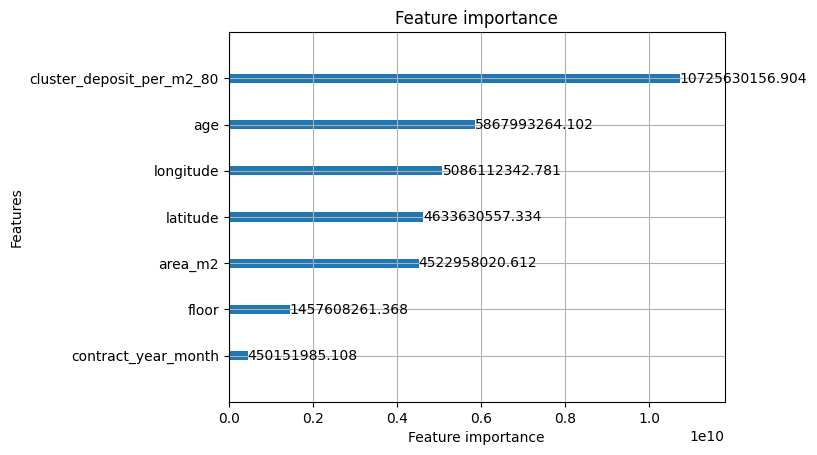

In [50]:
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=20)
plt.title('Feature importance')


# output

In [ ]:
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
# lgb_model.fit(X_train, y_train)

# batch로 나눠서 학습
batch_num = 30
batch_size = len(X_train) // batch_num
for i in range(0, len(X_train), batch_size):
    X_batch = all_train_data[i:i+batch_size]
    y_batch = deposit_per_area_all[i:i+batch_size]
    # lgb_model.fit(X_batch, y_batch)
    lgb_model.fit(X_batch, y_batch, init_model=lgb_model if i != 0 else None)


In [52]:
lgb_test_pred = lgb_model.predict(X_test)
sample_submission['deposit'] = lgb_test_pred
sample_submission.to_csv('output.csv', index=False, encoding='utf-8-sig')

NameError: name 'X_test' is not defined